# Image Segmentation (photutils.segmentation)

Documentation at the following link:

https://photutils.readthedocs.io/en/stable/segmentation.html

Photutils includes a general-use function to detect sources (both point-like and extended) in an image using a process called image segmentation in the computer vision field. After detecting sources using image segmentation, we can then measure their photometry, centroids, and morphological properties by using additional tools in Photutils.

# Source Extraction using Image Segmentation

Photutils provides tools to detect astronomical sources using image segmentation, which is a process of assigning a label to every pixel in an image such that pixels with the same label are part of the same source. The segmentation procedure implemented in Photutils is called the threshold method, where detected sources must have a minimum number of connected pixels that are each greater than a specified threshold value in an image. The threshold level is usually defined at some multiple of the background noise (sigma) above the background. The image can also be filtered before thresholding to smooth the noise and maximize the detectability of objects with a shape similar to the filter kernel.

In [1]:
from photutils.datasets import make_100gaussians_image
data = make_100gaussians_image()

${\bf\text{Note}}$: the following link give access to load a few example datasets:

https://photutils.readthedocs.io/en/stable/datasets.html

The source segmentation/extraction is performed using the $\color{blue}{\text{detect_sources()}}$ function. We will use a convenience function called $\color{blue}{\text{detect_threshold()}}$ to produce a 2D detection threshold image using simple sigma-clipped statistics to estimate the background level and RMS.

The threshold level is calculated using the `snr` input as the sigma level above the background. Here we generate a simple threshold at 2 sigma (per pixel) above the background:  

In [2]:
from photutils import detect_threshold
threshold = detect_threshold(data, snr=2.)

For more sophisticated analyses, one should generate a 2D background and background-only error image (e.g., from your data reduction or by using Background2D - see the Background Estimation Notebook). In that case, a 2-sigma threshold image is simply:

- threshold = bkg + (2.0 * bkg_rms)

For example:

**bkg_estimator = MedianBackground()**

**bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)**
                   
**threshold = bkg.background + (2. * bkg.background_rms)**

Let’s find sources that have 5 connected pixels that are each greater than the corresponding pixel-wise `threshold` level defined above (i.e. 2 sigma per pixel above the background noise). Note that by default “connected pixels” means “8-connected” pixels, where pixels touch along their edges or corners. One can also use “4-connected” pixels that touch only along their edges by setting `connectivity=4` in $\color{blue}{\text{detect_sources()}}$.

We will also input a 2D circular Gaussian kernel with a FWHM of 3 pixels to smooth the image some prior to thresholding:

In [3]:
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
sigma = 3.0 * gaussian_fwhm_to_sigma    # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)

The result is a $\color{blue}{\text{SegmentationImage}}$ object with the same shape as the data, where detected sources are labeled by different positive integer values. A value of zero is always reserved for the background. 

Let’s plot both the image and the segmentation image showing the detected sources:

Text(0.5, 1.0, 'Segmentation Image')

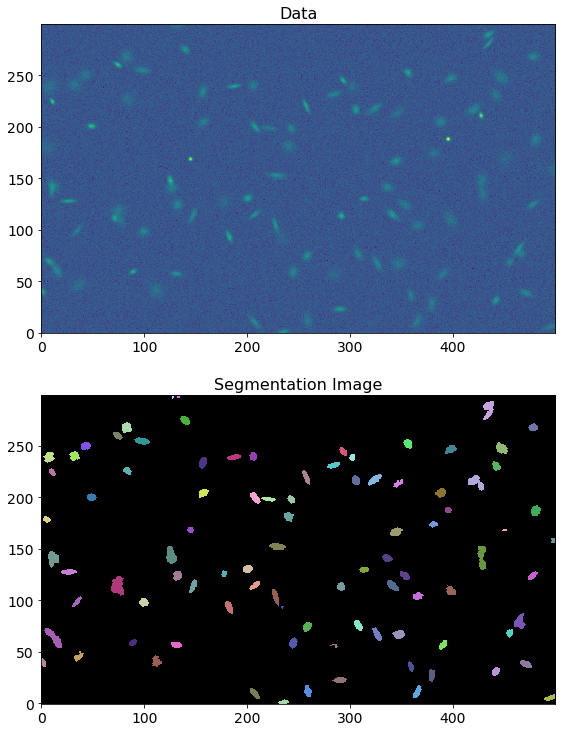

In [7]:
import numpy as np
from matplotlib import style, pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, norm=norm)
ax1.set_title('Data')
ax2.imshow(segm, cmap=segm.cmap(random_state=12345))
ax2.set_title('Segmentation Image')

# Source Deblending

In the example above, overlapping sources are detected as single sources. Separating those sources requires a deblending procedure, such as a multi-thresholding technique used by $\color{blue}{\text{SExtractor}}$. Photutils provides a $\color{blue}{\text{deblend_sources()}}$ function that deblends sources uses a combination of multi-thresholding and $\color{blue}{\text{watershed segmentation}}$. Note that in order to deblend sources, they must be separated enough such that there is a saddle between them.

The amount of deblending can be controlled with the two $\color{blue}{\text{deblend_sources()}}$ keywords:

- **`nlevels`** 
- **`contrast`**

`nlevels` is the number of multi-thresholding levels to use. 
`contrast` is the fraction of the total source flux that a local peak must have to be considered as a separate object.

In [8]:
from photutils import deblend_sources
segm_deblend = deblend_sources(data, segm, npixels=5,
                               filter_kernel=kernel, nlevels=32,
                               contrast=0.001)

/Users/correnti/anaconda/envs/astroconda/lib/python3.5/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


Let's plot the deblended sources:

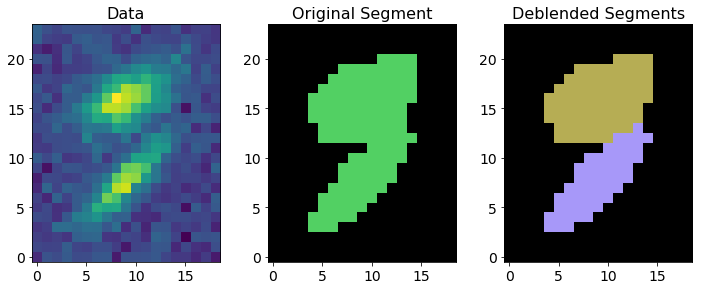

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
slc = (slice(273, 297), slice(425, 444))
ax1.imshow(data[slc], origin='lower')
ax1.set_title('Data')
ax2.imshow(segm.data[slc], origin='lower',
           cmap=segm.cmap(random_state=123))
ax2.set_title('Original Segment')
ax3.imshow(segm_deblend.data[slc], origin='lower',
           cmap=segm_deblend.cmap(random_state=123))
ax3.set_title('Deblended Segments')
plt.tight_layout()

# Modifying a Segmentation Image

The $\color{blue}{\text{SegmentationImage}}$ object provides several methods that can be used to visualize or modify itself (e.g., combining labels, removing labels, removing border segments) prior to measuring source photometry and other source properties, including:

- $\color{blue}{\text{relabel()}}$: Relabel one or more label numbers.
- $\color{blue}{\text{relabel_sequential()}}$: Relable the label numbers sequentially.
- $\color{blue}{\text{keep_labels()}}$: Keep only certain label numbers.
- $\color{blue}{\text{remove_labels()}}$: Remove one or more label numbers.
- $\color{blue}{\text{remove_border_labels()}}$: Remove labeled segments near the image border.
- $\color{blue}{\text{remove_masked_labels()}}$: Remove labeled segments located within a masked region.
- $\color{blue}{\text{outline_segments()}}$: Outline the labeled segments for plotting.

# Centroids, Photometry, and Morphological Properties

The $\color{blue}{\text{source_properties()}}$ function is the primary tool for measuring the centroids, photometry, and morphological properties of sources defined in a segmentation image. When the segmentation image is generated using image thresholding (e.g., using $\color{blue}{\text{detect_sources()}}$), the source segments represent the isophotal footprint of each source and the resulting photometry is effectively isophotal photometry.

$\color{blue}{\text{source_properties()}}$ returns a $\color{blue}{\text{SourceCatalog}}$ object, which acts in part like a list of $\color{blue}{\text{SourceProperties}}$ objects, one for each segmented source (or a specified subset of sources). An Astropy $\color{blue}{\text{QTable}}$ of source properties can be generated using the $\color{blue}{\text{to_table()}}$ method.

Documentation for $\color{blue}{\text{source_properties}}$ and $\color{blue}{\text{detect_sources}}$ at the following links:

https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceProperties.html#photutils.segmentation.SourceProperties

https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html#photutils.segmentation.detect_sources

For a different source detection method see also:

https://photutils.readthedocs.io/en/stable/detection.html

Let’s detect sources and measure their properties in a synthetic image. For this example, we will use the $\color{blue}{\text{Background2D}}$ class to produce a background and background noise image. We define a 2D detection threshold image using the background and background RMS images. We set the threshold at 2 sigma (per pixel) above the background:

In [11]:
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
threshold = bkg.background + (2. * bkg.background_rms)

In [12]:
from astropy.stats import gaussian_fwhm_to_sigma
sigma = 3.0 * gaussian_fwhm_to_sigma    # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
npixels = 5
segm = detect_sources(data, threshold, npixels=npixels,
                      filter_kernel=kernel)
segm_deblend = deblend_sources(data, segm, npixels=npixels,
                               filter_kernel=kernel, nlevels=32,
                               contrast=0.001)

Text(0.5, 1.0, 'Segmentation Image')

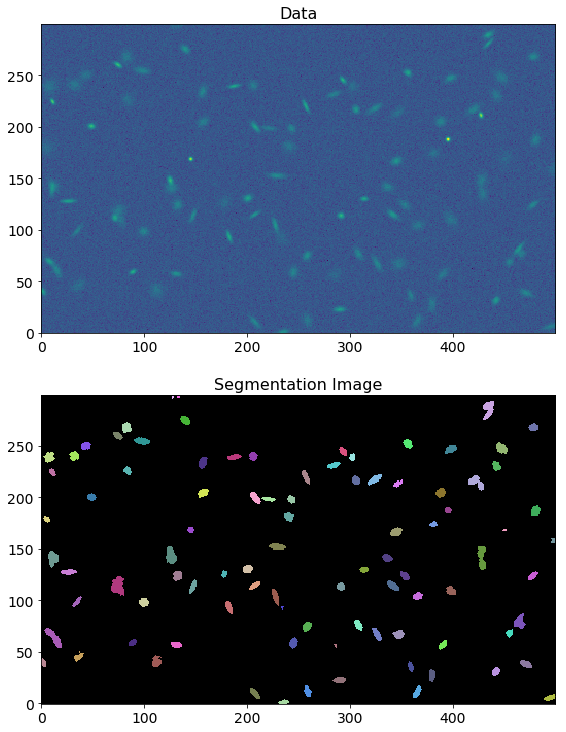

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, norm=norm)
ax1.set_title('Data')
cmap2= segm.cmap(random_state=12345)
ax2.imshow(segm, cmap=cmap2)
ax2.set_title('Segmentation Image')

Now let’s measure the properties of the detected sources defined in the segmentation image using the simplest call to $\color{blue}{\text{source_properties()}}$. The output $\color{blue}{\text{QTable}}$ of source properties is generated by the $\color{blue}{\text{SourceCatalog to_table()}}$ method. Each row in the table represents a source. The columns represent the calculated source properties.

In [14]:
# For this particular example we plot in the table the following values:

# xcentroid and ycentroid = X and Y coordinate of the centroid within the source segment
# cxx = SExtractor’s CXX ellipse parameter in units of pixel**(-2).
# cxy = SExtractor’s CXY ellipse parameter in units of pixel**(-2).
# cyy = SExtractor’s CYY ellipse parameter in units of pixel**(-2).

from photutils import source_properties
cat = source_properties(data, segm_deblend)
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['cxx'].info.format = '.2f'
tbl['cxy'].info.format = '.2f'
tbl['cyy'].info.format = '.2f'
print(tbl)

 id xcentroid ycentroid sky_centroid ...   cxx      cxy      cyy   
       pix       pix                 ... 1 / pix2 1 / pix2 1 / pix2
--- --------- --------- ------------ ... -------- -------- --------
  1    235.22      1.25         None ...     0.17    -0.20     0.99
  2    493.82      5.77         None ...     0.16    -0.32     0.61
  3    207.30     10.02         None ...     0.37     0.49     0.30
  4    364.75     11.13         None ...     0.39    -0.33     0.18
  5    258.37     11.77         None ...     0.37     0.15     0.16
  6    289.49     22.41         None ...     0.12    -0.04     0.54
  7    379.28     27.29         None ...     0.41    -0.01     0.10
  8    441.34     31.08         None ...     0.33    -0.17     0.27
  9    358.49     35.87         None ...     0.66     0.30     0.20
 10    470.51     38.45         None ...     0.15     0.23     0.37
...       ...       ...          ... ...      ...      ...      ...
 87    127.38    297.21         None ...     4.8

Let’s use the measured morphological properties to define approximate isophotal ellipses for each source. Here we define an $\color{blue}{\text{EllipticalAperture}}$ object for each source using its calculated centroid positions ($\color{blue}{\text{xcentroid}}$ and $\color{blue}{\text{ycentroid)}}$ , semimajor and semiminor axes lengths ($\color{blue}{\text{semimajor_axis_sigma}}$ and $\color{blue}{\text{semiminor_axis_sigma)}}$, and orientation ($\color{blue}{\text{orientation)}}$:

In [15]:
from photutils import EllipticalAperture
cat = source_properties(data, segm_deblend)
r = 3.    # approximate isophotal extent
apertures = []
for obj in cat:
    position = (obj.xcentroid.value, obj.ycentroid.value)
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

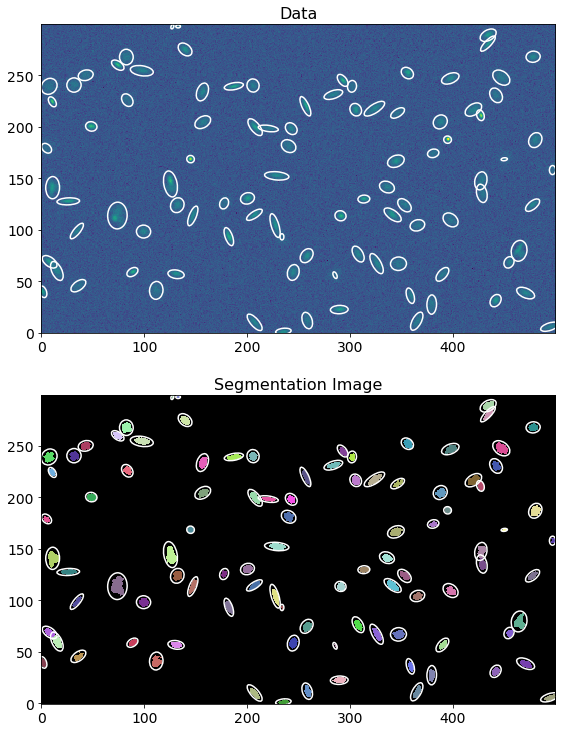

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
plt.rcParams['image.cmap'] = 'viridis'
ax1.imshow(data, norm = norm)
ax1.set_title('Data')
ax2.imshow(segm_deblend,
           cmap=segm_deblend.cmap(random_state=12345))
ax2.set_title('Segmentation Image')
for aperture in apertures:
    aperture.plot(color='white', lw=1.5, ax=ax1)
    aperture.plot(color='white', lw=1.5, ax=ax2)

We can also specify a specific subset of sources, defined by their label numbers in the segmentation image:

In [25]:
labels = [1, 5, 20, 50, 75, 80]
cat2 = source_properties(data, segm_deblend, labels=labels)
tbl2 = cat2.to_table()
tbl2['xcentroid'].info.format = '.2f'  # optional format
tbl2['ycentroid'].info.format = '.2f'
tbl2['cxx'].info.format = '.2f'
tbl2['cxy'].info.format = '.2f'
tbl2['cyy'].info.format = '.2f'
print(tbl2)

 id xcentroid ycentroid sky_centroid ...   cxx      cxy      cyy   
       pix       pix                 ... 1 / pix2 1 / pix2 1 / pix2
--- --------- --------- ------------ ... -------- -------- --------
  1    235.22      1.25         None ...     0.17    -0.20     0.99
  5    258.37     11.77         None ...     0.37     0.15     0.16
 20    347.00     66.94         None ...     0.15    -0.01     0.21
 50    145.06    168.55         None ...     0.66     0.05     0.71
 75    301.86    239.25         None ...     0.47    -0.05     0.28
 80     43.20    250.01         None ...     0.18    -0.08     0.34


In [26]:
r = 3.    # approximate isophotal extent
apertures = []
for obj in cat2:
    position = (obj.xcentroid.value, obj.ycentroid.value)
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

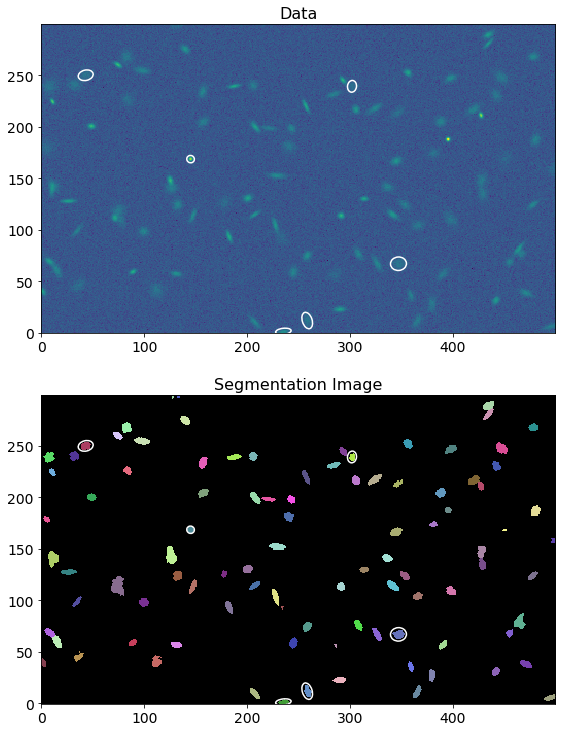

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
plt.rcParams['image.cmap'] = 'viridis'
ax1.imshow(data, norm = norm)
ax1.set_title('Data')
ax2.imshow(segm_deblend,
           cmap=segm_deblend.cmap(random_state=12345))
ax2.set_title('Segmentation Image')
for aperture in apertures:
    aperture.plot(color='white', lw=1.5, ax=ax1)
    aperture.plot(color='white', lw=1.5, ax=ax2)

# Background Properties

Like with $\color{blue}{\text{aperture_photometry()}}$, the $\bf\text{data}$ array that is input to $\color{blue}{\text{source_properties()}}$ should be background subtracted. If you input the background image that was subtracted from the data into the $\bf\text{background}$ keyword of $\color{blue}{\text{source_properties()}}$, the background properties for each source will also be calculated:

In [28]:
labels = [1, 5, 20, 50, 75, 80]
cat = source_properties(data, segm_deblend, labels=labels,
                        background=bkg.background)
columns = ['id', 'background_at_centroid', 'background_mean',
           'background_sum']
tbl4 = cat.to_table(columns=columns)
tbl4['background_at_centroid'].info.format = '{:.10f}'  # optional format
tbl4['background_mean'].info.format = '{:.10f}'
tbl4['background_sum'].info.format = '{:.10f}'
print(tbl4)

 id background_at_centroid background_mean background_sum
--- ---------------------- --------------- --------------
  1           5.2020410556    5.2021662094 187.2779835383
  5           5.2140028193    5.2139893924 302.4113847608
 20           5.2787978012    5.2785772173 385.3361368595
 50           5.1896627086    5.1895516008 171.2552028270
 75           5.1409594224    5.1408425626 185.0703322539
 80           5.2109825281    5.2108402505 286.5962137759


# Photometric Errors

$\color{blue}{\text{source_properties()}}$ requires inputting a $\it\text{total}$ error array, i.e. the background-only error plus Poisson noise due to individual sources. The $\color{blue}{\text{calc_total_error()}}$ function can be used to calculate the total error array from a background-only error array and an effective gain.

The $\bf\text{effective_gain}$, which is the ratio of counts (electrons or photons) to the units of the data, is used to include the Poisson noise from the sources. $\bf\text{effective_gain}$ can either be a scalar value or a 2D image with the same shape as the $\bf\text{data}$. A 2D effective gain image is useful for mosaic images that have variable depths (i.e., exposure times) across the field. For example, one should use an exposure-time map as the $\bf\text{effective_gain}$ for a variable depth mosaic image in count-rate units.

Let’s assume our synthetic data is in units of electrons per second. In that case, the $\bf\text{effective_gain}$ should be the exposure time (here we set it to 500 seconds). Here we use $\color{blue}{\text{calc_total_error()}}$ to calculate the total error and input it into the $\color{blue}{\text{source_properties()}}$ function. When a total $\bf\text{error}$ is input, the $\color{blue}{\text{source_sum_err}}$ property is calculated. $\color{blue}{\text{source_sum}}$ and $\color{blue}{\text{source_sum_err}}$ are the instrumental flux and propagated flux error within the source segments:

In [29]:
from photutils.utils import calc_total_error
labels = [1, 5, 20, 50, 75, 80]
effective_gain = 500.
error = calc_total_error(data, bkg.background_rms, effective_gain)
cat = source_properties(data, segm_deblend, labels=labels, error=error)
columns = ['id', 'xcentroid', 'ycentroid', 'source_sum',
           'source_sum_err']
tbl5 = cat.to_table(columns=columns)
tbl5['xcentroid'].info.format = '{:.4f}'  # optional format
tbl5['ycentroid'].info.format = '{:.4f}'
for col in tbl5.colnames:
    tbl5[col].info.format = '%.8g'  # for consistent table output
print(tbl5)

 id xcentroid ycentroid source_sum source_sum_err
       pix       pix                             
--- --------- --------- ---------- --------------
  1 235.21604 1.2457344  594.21933      12.787658
  5 258.37099 11.769376  684.71547      16.326605
 20 346.99975 66.942777  864.97776      18.677809
 50 145.05911 168.54961   885.9582      11.908449
 75 301.86414 239.25337  391.16559      12.080326
 80 43.202278 250.00997  627.67268      15.812197
